# Arena Class Examples

## In this notebook, we provide examples to create arenas so an agent can interact with.
Each of these arenas has common methods that resemble Open AI gym structure (soon we will built our classes on top of Open AI gym environments).
The package has methods to build 2D arenas with arbitrary shapes described by "walls" that can be easely change for each arena. There are also arenas that resemble sampling rate and dimensions of specific experiments (see "Experiment Class Example" notebook), one using these arenas, the experimental data (animal trajectory and neural recording) is loaded from its respective dataset, and can be used to compare results againts the artificial agent.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt

First, let's initialize a random agent to evaluate on each envirnoment

In [2]:
from neuralplayground.agents import RandomAgent
agent = RandomAgent()

## 2D arenas

These arenas are maleable and can take arbitrary shapes based on the configuration its walls. Here we start by a default square room.

In [3]:
from neuralplayground.arenas import Simple2D, ConnectedRooms

We initialize the arena/environment

In [4]:
time_step_size = 0.1 #seg
agent_step_size = 3

# Init environment
env = Simple2D(time_step_size = time_step_size,
               agent_step_size = agent_step_size,
               arena_x_limits=(-100, 100), 
               arena_y_limits=(-100, 100))

For all arenas, you can run the same "training loop" where the agents recieves and observation from the environment (in this case the position), then chose an action based on the observation, and observe the outcome from the environment given the action

In [5]:
n_steps = 5000

# Initialize environment
obs, state = env.reset()
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

The position history of the agent is saved within the environment, you can plot the trajectory using the method ```plot_trajectory```, or have access to the positions by asking for the ```history``` attribute of the environment class (```h = env.history```)

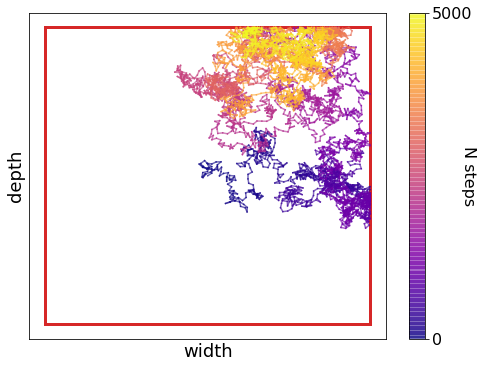

In [6]:
ax = env.plot_trajectory()
fontsize = 18
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
# plt.savefig("two_rooms.pdf", bbox_inches="tight")
plt.show()

Let's try some other environments. There is a ```Connected room``` class (hopefully will include neural recordings from [this paper](https://www.sciencedirect.com/science/article/pii/S0893608019302631) soon).

In [7]:
time_step_size = 0.1 #seg
agent_step_size = 3

# Init environment
env = ConnectedRooms(time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

In [8]:
n_steps = 10000

# Initialize environment
obs, state = env.reset()
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

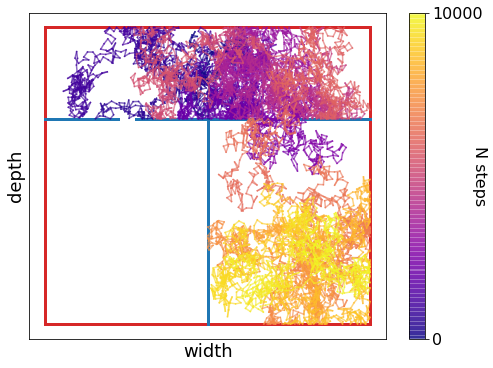

In [9]:
ax = env.plot_trajectory()
fontsize = 18
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
# plt.savefig("two_rooms.pdf", bbox_inches="tight")
plt.show()

Maybe you didn't noticed this detail, but the inner walls in the plot are blue! and these are the walls that are maleable and listed in the attribute called ```custom_walls```, we can easely change the walls by overriding a method from these arenas called ```_create_custom_walls```. In this method, the ```custom_walls``` attribute is define to built the blue walls within the limits of the arena (which are the red walls). So, for example, the ```custom_walls``` of the ```ConnectedRooms``` class are

In [10]:
env.custom_walls, env.custom_walls[0].shape

([array([[  0.,   0.],
         [  0., -90.]]),
  array([[-90.,   0.],
         [-50.,   0.]]),
  array([[-40.,   0.],
         [  0.,   0.]]),
  array([[ 0.,  0.],
         [40.,  0.]]),
  array([[50.,  0.],
         [90.,  0.]])],
 (2, 2))

Each element in the ```custom_walls``` list is a 2x2 matrix where the first row is the (x, y) coordinate of the first limit of the wall, and the second row is the (x, y) coordinate of the second limit of the wall. Just by modifying this attribute (or overriding ```_create_custom_walls```) we can change the shape of the arena. Let's see an example:

In [11]:
class TwoArms(ConnectedRooms):
    
    def _create_custom_walls(self):  
        
        # this method is called every time an arena from this class is instantiated
        
        self.custom_walls = []  # Create the list with custom_walls (needs to be created)
        self.custom_walls.append(np.array([[-25, 0], [-25, -self.singleroom_ysize]]))  # singleroom_ysize are attributes from the connected room class
        self.custom_walls.append(np.array([[25, 0], [25, -self.singleroom_ysize]]))    
        self.custom_walls.append(np.array([[-self.singleroom_xsize, 0], [-25, 0]]))
        self.custom_walls.append(np.array([[self.singleroom_xsize, 0], [25, 0]]))

We just changed the custom_wall list that is built when instantiate the class, let's see how it looks like

In [12]:
env_name = "two_arms"
time_step_size = 0.1 #seg
agent_step_size = 5

# Init environment
env = TwoArms(environment_name=env_name,
              time_step_size = time_step_size,
              agent_step_size = agent_step_size)

In [13]:
n_steps = 5000

# Initialize environment
obs, state = env.reset(custom_state=[0,0])
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

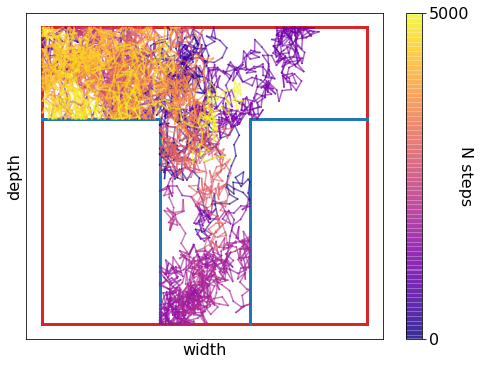

In [14]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
# plt.savefig("two_arms.pdf", bbox_inches="tight")
plt.show()

You can also define functions that generate more comples walls, for example, we defined a ```create_circular_wall``` (check in [utils](https://github.com/ClementineDomine/EHC_model_comparison/blob/main/neuralplayground/utils.py)) that gives you a list of stright walls that simulate a circle. So let's create a circular hall arena

In [15]:
from neuralplayground.arenas import Simple2D
from neuralplayground.utils import create_circular_wall

In [16]:
class CircularArena(Simple2D):
    
    def _create_custom_walls(self):
        self.custom_walls = create_circular_wall(center=np.array([0, 0]), radius=50)  # One inner circle
        self.custom_walls += create_circular_wall(center=np.array([0, 0]), radius=75)  # One outer circle

In [17]:
time_step_size = 0.1 #seg
agent_step_size = 5
arena_x_limits = np.array((-100, 100))
arena_y_limits = np.array((-100, 100))

# Init environment
env = CircularArena(time_step_size = time_step_size,
                    agent_step_size = agent_step_size,
                    arena_x_limits=arena_x_limits,
                    arena_y_limits=arena_y_limits)

In [18]:
n_steps = 5000

# We start the agent within the circular hall, if we don't do this, the agent might start from outside the hall
# Try it! by removing the custom_state argument
obs, state = env.reset(custom_state=[-70,0])
# obs, state = env.reset(custom_state = [-90, 0])
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

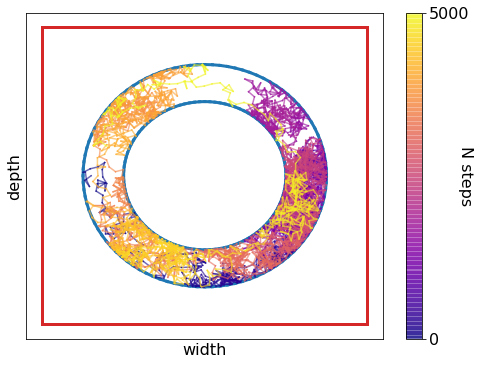

In [19]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
# plt.savefig("circle.pdf", bbox_inches="tight")
plt.show()

## Arenas with experimental data

Some of the arenas are pre-configured to follow the dimensions and sampling rate of a real experiment. When initializing these arenas, the experimental data will be automatically loaded using the Experimental Data Class (see [these examples](https://github.com/ClementineDomine/EHC_model_comparison/blob/main/examples/experimental_data_examples.ipynb)). The idea is to create artificial environment with the same structure as the experiments, to then compare with experimental recordings! For example

In [20]:
from neuralplayground.arenas import Sargolini2006

In [21]:
env = Sargolini2006(environment_name=env_name,
                    time_step_size = time_step_size,
                    agent_step_size = agent_step_size)

In [22]:
recording_list = env.data.show_data()  # env.data has an object of the experiment class with Sargolini et al data

Dataframe with recordings


,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


(array([-11.33495021, -11.33495021, -12.81476112, ...,   2.96988862,
          3.70979408,   3.70979408]),
 array([-33.91940175, -33.91940175, -33.91940175, ...,   1.84269531,
          2.08933047,   2.08933047]),
 array([0.0000e+00, 2.0000e-02, 4.0000e-02, ..., 5.9994e+02, 5.9996e+02,
        5.9998e+02]))

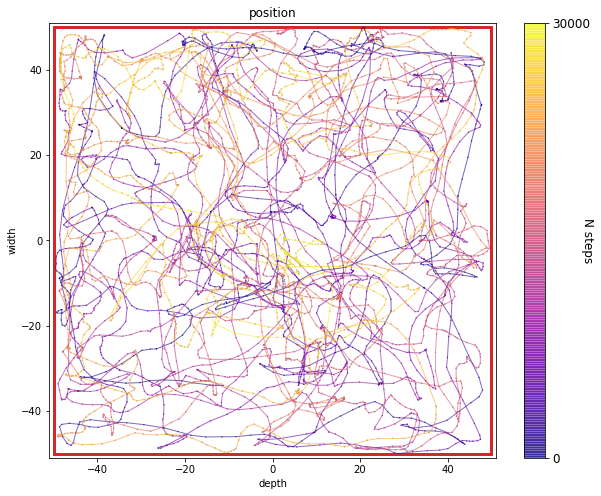

In [23]:
env.data.plot_trajectory(recording_index=3, plot_every=5)

In [24]:
n_steps = 5000

# The dimensions of the arena are the same as the one from the experiment (in cm)
obs, state = env.reset()
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

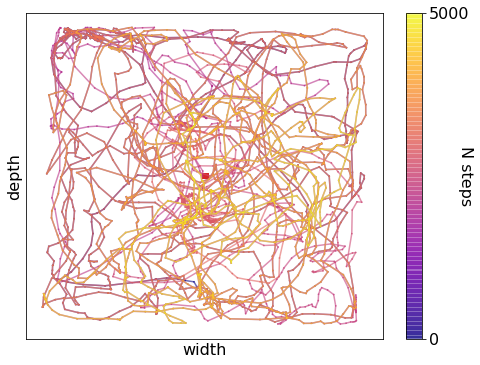

In [25]:
ax = env.plot_trajectory()
fontsize = 16
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
plt.show()

## Dynamic arenas

Some of these environment might change through time, like in [Wernle et al 2018](https://www.nature.com/articles/s41593-017-0036-6). In this experiment, mice would explore an arena with a wall in between that doesn't allow the animal to cross to the other side. After a few minutes, the mouse would be moved to the other side of the arena, still with the wall. Then, the wall is removed, and the mouse is allowed to explore both sides of the arena. The idea was to study how grid fields merge after removing the wall in between. Let's run this experiment using a built in class.

In [26]:
from neuralplayground.arenas import Wernle2018

In [27]:
time_step_size = 0.2
agent_step_size = 3
merging_time = 20  # Time in seconds to remove 
switch_time = 10  # Time in second to move the mouse to the other side of the arena
n_steps = ((merging_time + switch_time)*60) / time_step_size

env = Wernle2018(merge_time=merging_time,
                 switch_time=switch_time,
                 time_step_size=time_step_size,
                 agent_step_size=agent_step_size)

Again, we have acess to the data from this experiment. The data is loaded automatically and define as an attribute of the arena class called ```data```. Below, we plot the grid fields before and after merging time recorded in the experiment.

array([[<AxesSubplot:title={'center':'Before merging'}>,
        <AxesSubplot:title={'center':'After merging'}>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

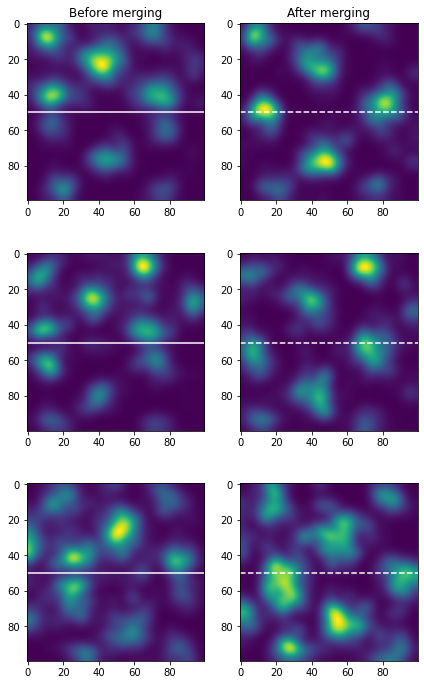

In [28]:
env.data.plot_cell_comparison(session_index=(125, 126, 127))

In the following loop, we run the arena-agent interaction that works in the same way as the previous ones. The switching of rooms and removing of the mid wall is a process written in the class, so we don't need to care about coding this part. If you want to modify or built your own dynamic arena, it is just a matter of change the ```custom_wall``` list, you can use [this same class](https://github.com/ClementineDomine/EHC_model_comparison/blob/main/neuralplayground/arenas/wernle_2018.py) as an example. We will just add an "if" statement to plot the exploration of the agent before and after switching rooms but **before merging**.

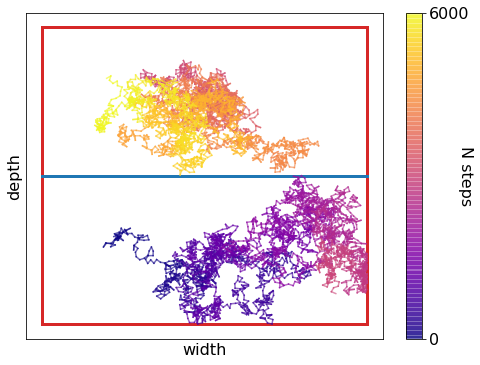

In [29]:
obs, state = env.reset()

for j in range(round(n_steps)):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    if j == ((merging_time*60)/time_step_size)-1:
        ax = env.plot_trajectory()
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        # plt.savefig("pre_merge.pdf", bbox_inches="tight")

Finally, we can plot the exploration of the agent after merging (removing the wall in the middle) by first getting the whole history of the interaction from the arena, saved in the attribute ```env.history```, then taking the history that is just exploring the merged room. We can re-use the ```plot_trajectory``` method to show any history, so we take the time points we are intereseted in, then feed it to the method

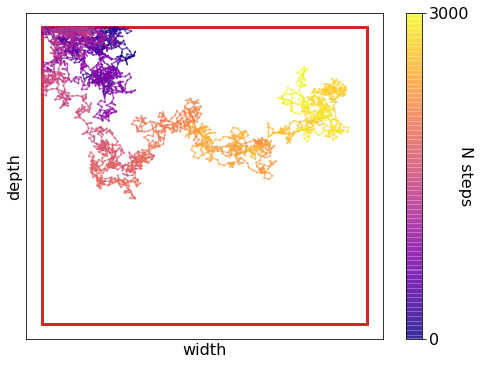

In [30]:
merged_history = env.history[int((merging_time*60)/time_step_size):]
ax=env.plot_trajectory(history_data=merged_history)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

# plt.savefig("after_merge.pdf", bbox_inches="tight")
plt.show()